In [52]:
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import core.constants as constants
import core.model_utils as model_utils

In [53]:
df = pd.read_json('./../data/polish_translated/sarcasm/sarcasm_headlines_dataset_pl.json')
df

,is_sarcastic,headline,article_link,headline_pl
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...,Naukowcy z lat trzydziestych odkrywają zegar z...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko..."
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...,Jedz warzywa: 9 pysznie różnych przepisów
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...,"matka jest bardzo blisko użycia słowa ""streami..."
...,...,...,...,...
28614,1,jews to celebrate rosh hashasha or something,https://www.theonion.com/jews-to-celebrate-ros...,Żydzi świętują Rosh Hashasha czy coś
28615,1,internal affairs investigator disappointed con...,https://local.theonion.com/internal-affairs-in...,Śledczy spraw wewnętrznych rozczarowany spiski...
28616,0,the most beautiful acceptance speech this week...,https://www.huffingtonpost.com/entry/andrew-ah...,Najpiękniejsza przemowa akceptacyjna w tym tyg...
28617,1,mars probe destroyed by orbiting spielberg-gat...,https://www.theonion.com/mars-probe-destroyed-...,Mars zniszczony przez pałac kosmiczny na orbic...


In [54]:
df = df.drop(columns=['article_link', 'headline'])
df

,is_sarcastic,headline_pl
0,1,Naukowcy z lat trzydziestych odkrywają zegar z...
1,0,"Reprezentantka rządu USA wyjaśnia, dlaczego Ko..."
2,0,Jedz warzywa: 9 pysznie różnych przepisów
3,1,Nieprzyjemna pogoda uniemożliwia kłamcy dotarc...
4,1,"matka jest bardzo blisko użycia słowa ""streami..."
...,...,...
28614,1,Żydzi świętują Rosh Hashasha czy coś
28615,1,Śledczy spraw wewnętrznych rozczarowany spiski...
28616,0,Najpiękniejsza przemowa akceptacyjna w tym tyg...
28617,1,Mars zniszczony przez pałac kosmiczny na orbic...


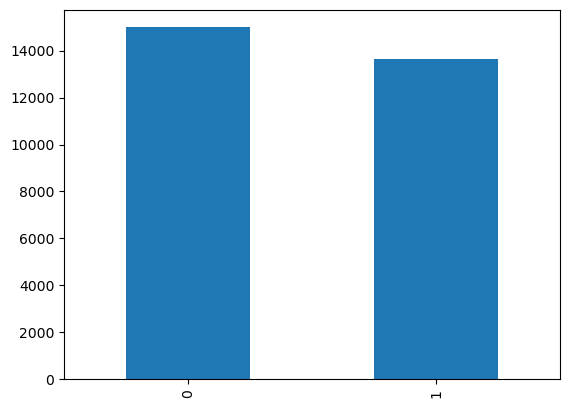

In [55]:
data = df["is_sarcastic"]
data.value_counts().plot.bar()
plt.show()

In [56]:
from datasets import Dataset

raw_dataset = Dataset.from_pandas(df).remove_columns("__index_level_0__")
raw_dataset

Dataset({
    features: ['is_sarcastic', 'headline_pl'],
    num_rows: 28619
})

In [57]:
from transformers import AutoTokenizer

checkpoint = "dkleczek/bert-base-polish-uncased-v1"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [58]:
def tokenize_function(example):
    return tokenizer(example["headline_pl"], truncation=True)


tokenized_dataset = raw_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/28619 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [75]:
# Train set: 80%, Validation set: 10%, Test set: 10%
tokenized_train_dataset, tokenized_val_dataset, tokenized_test_dataset = model_utils.split_train_val_test(
    tokenized_dataset,
    train_size=0.8,
    test_size_of_val_test_batch=0.5,
    shuffle=True,
    seed=42)

In [76]:
tokenized_train_dataset = tokenized_train_dataset.select(
    (
        i for i in range(len(tokenized_train_dataset))
        if i not in {15667, 20698}
    )
)

In [77]:
tokenized_train_dataset['headline_pl'][:5]

['Profil randkowy płasko stwierdza, że mężczyzna szuka kogoś, kogo może kontrolować',
 'Sasha i Malia Obama próbowali (i nie udało im się) spotkać gwiazdę piłki nożnej w Argentynie',
 'Sieci przerwą dzienne pokazy prawdziwego mydła, gdy komediant zeznaje',
 'Najwyższy anglikański przywódca w Ugandzie podwaja prawo antygejowskie',
 'Usterka komputera Wells Fargo przypadkowo zamyka wszystkie 5700 oddziałów']

In [78]:
from transformers import DataCollatorWithPadding

columns = ["attention_mask", "input_ids", "token_type_ids"]
label_cols = ["is_sarcastic"]
batch_size = 8
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="tf")

tf_train_dataset = model_utils.convert_to_tf_dataset(tokenized_train_dataset, columns, label_cols, data_collator,
                                                     batch_size)
tf_val_dataset = model_utils.convert_to_tf_dataset(tokenized_val_dataset, columns, label_cols, data_collator,
                                                   batch_size)
tf_test_dataset = model_utils.convert_to_tf_dataset(tokenized_test_dataset, columns, label_cols, data_collator,
                                                    batch_size)

C:\Users\Karol\anaconda3\envs\ml-tf2gpu\lib\site-packages\datasets\arrow_dataset.py:388: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(


In [102]:
# Model parameters
training_number = 4
model_name = "sarcasm_pl_bert"

training_name = f"training_{training_number}"
checkpoint_filename_template = "cp-{epoch:04d}.ckpt"
checkpoints_dir = os.path.join(constants.TRAINING_CHECKPOINTS_PATH, model_name, training_name)
figures_dir = f"./../documentation/models/{model_name}/figures"
checkpoint_path = os.path.join(checkpoints_dir, checkpoint_filename_template)

In [80]:
# Callbacks
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, verbose=1, save_weights_only=True)
early_stop_cb = tf.keras.callbacks.EarlyStopping(patience=3)
callbacks = [checkpoint_cb, early_stop_cb]

In [81]:
from tensorflow.keras.optimizers.schedules import PolynomialDecay
from tensorflow.keras.optimizers import Adam

num_epochs = 10
num_train_steps = len(tf_train_dataset) * num_epochs
lr_scheduler = PolynomialDecay(
    initial_learning_rate=5e-5, end_learning_rate=0.0, decay_steps=num_train_steps
)

optimizer = Adam(learning_rate=lr_scheduler)

In [82]:
from transformers import TFAutoModelForSequenceClassification

model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2, from_pt=True)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
# Compile
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = ["accuracy"]
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [84]:
history = model.fit(tf_train_dataset, validation_data=tf_val_dataset, epochs=num_epochs, callbacks=callbacks)

Epoch 1/10
2862/2862 [==============================] - 199s 66ms/step - loss: 0.4155 - accuracy: 0.8122 - val_loss: 0.3433 - val_accuracy: 0.8571

Epoch 00001: saving model to ./../training_checkpoints\sarcasm_pl_bert\training_4\cp-0001.ckpt
Epoch 2/10
2862/2862 [==============================] - 184s 64ms/step - loss: 0.2131 - accuracy: 0.9206 - val_loss: 0.4114 - val_accuracy: 0.8592

Epoch 00002: saving model to ./../training_checkpoints\sarcasm_pl_bert\training_4\cp-0002.ckpt
Epoch 3/10
2862/2862 [==============================] - 189s 66ms/step - loss: 0.1016 - accuracy: 0.9656 - val_loss: 0.5029 - val_accuracy: 0.8393

Epoch 00003: saving model to ./../training_checkpoints\sarcasm_pl_bert\training_4\cp-0003.ckpt
Epoch 4/10
2862/2862 [==============================] - 184s 64ms/step - loss: 0.0540 - accuracy: 0.9834 - val_loss: 0.5632 - val_accuracy: 0.8543

Epoch 00004: saving model to ./../training_checkpoints\sarcasm_pl_bert\training_4\cp-0004.ckpt


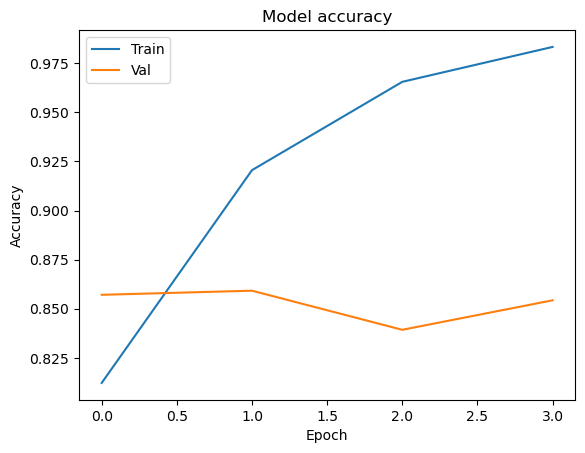

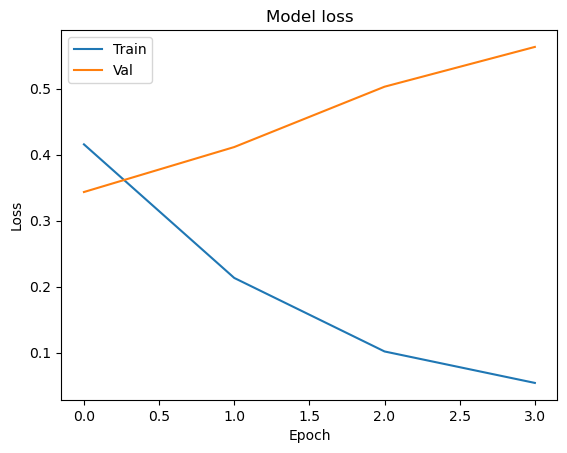

In [103]:
model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['accuracy', 'val_accuracy'],
                                           title='Model accuracy',
                                           y_label='Accuracy',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_accuracy.png")

model_utils.plot_and_save_fig_from_history(history,
                                           attributes=['loss', 'val_loss'],
                                           title='Model loss',
                                           y_label='Loss',
                                           x_label='Epoch',
                                           legend_descriptors=['Train', 'Val'],
                                           figure_dir_path=figures_dir,
                                           figure_filename=f"{training_name}_loss.png")

In [86]:
best_model = model_utils.get_best_model_from_checkpoints(model, history,
                                                         checkpoints_dir=checkpoints_dir,
                                                         checkpoint_filename_template=checkpoint_filename_template)

In [87]:
model_utils.save_model(best_model, model_name=model_name, training_number=training_number,
                       saved_models_dir=constants.SAVED_MODEL_LOCATION,
                       default_model_version=constants.DEFAULT_MODEL_VERSION)

INFO:tensorflow:Assets written to: ./../trained_models\sarcasm_pl_bert_4\1\assets


INFO:tensorflow:Assets written to: ./../trained_models\sarcasm_pl_bert_4\1\assets


In [88]:
# Evaluation
best_model.evaluate(tf_test_dataset, batch_size=batch_size)

358/358 [==============================] - 9s 25ms/step - loss: 0.3444 - accuracy: 0.8574


[0.34440281987190247, 0.857442319393158]

In [89]:
class_preds = model_utils.get_class_preds(model, tf_test_dataset)

In [90]:
precision, recall, f1 = model_utils.get_classification_evaluation_metrics(
    class_actual=tokenized_test_dataset['is_sarcastic'],
    class_preds=class_preds)

print(f"Precision score: ", precision)
print(f"Recall score: ", recall)
print(f"F1 score: ", f1)

Precision score:  0.8966639544344996
Recall score:  0.7968185104844541
F1 score:  0.8437978560490046


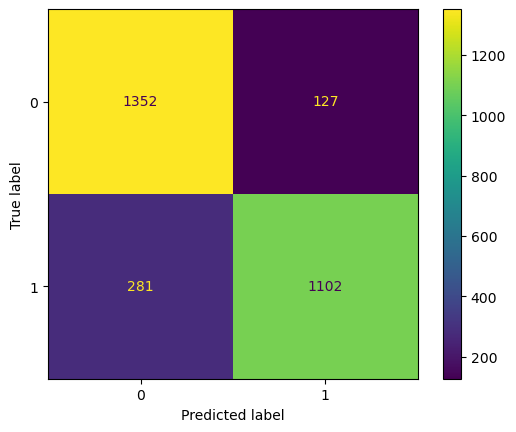

In [104]:
model_utils.plot_and_save_conf_matrix(class_actual=tokenized_test_dataset['is_sarcastic'],
                                      class_preds=class_preds,
                                      figure_dir_path=figures_dir,
                                      figure_filename=f"{training_name}_confmatrix.png")

In [92]:
model_utils.print_incorrectly_predicted_texts(texts=raw_dataset['headline_pl'],
                                              class_actual=raw_dataset['is_sarcastic'],
                                              class_preds=class_preds)


            BAD PREDICTION:
            - INDEX: 3
            - TEXT: Nieprzyjemna pogoda uniemożliwia kłamcy dotarcie do pracy
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 5
            - TEXT: Białe dziedzictwo
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 7
            - TEXT: Darowizna Richarda Brandona na ocieplenie świata prawie tyle samo, co koszt nieudanych lotów balonem
            - PREDICTED VALUE: 0
            - CORRECT VALUE: 1
            

            BAD PREDICTION:
            - INDEX: 9
            - TEXT: Wielu rodziców zna ten scenariusz.
            - PREDICTED VALUE: 1
            - CORRECT VALUE: 0
            

            BAD PREDICTION:
            - INDEX: 10
            - TEXT: Ta lesbijka jest uważana za ojca w Indiach (i niesamowita w tym)
            - PREDICTED VALUE: 1
            - CORRECT

In [93]:
tokenized_test_dataset

Dataset({
    features: ['is_sarcastic', 'headline_pl', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 2862
})

In [94]:
test_df = pd.DataFrame(
    list(zip(tokenized_test_dataset['headline_pl'], tokenized_test_dataset['is_sarcastic'], class_preds)),
    columns=['headline_pl', 'is_sarcastic', 'prediction'])
test_df

,headline_pl,is_sarcastic,prediction
0,"Szef uważa, że kobieta pracownik może być goto...",1,1
1,"""New York Times"": tyran wybija stos sondaży z ...",1,0
2,"przygotuj się na lizanie w tej przyczepie ""for...",0,0
3,"hare krishnas: 'hare krishna, hare krishna, kr...",1,0
4,Powerball wyciąga plastikowe kulki z solanki z...,1,1
...,...,...,...
2857,Lena Dunham na czerwonym dywanie,0,0
2858,PayPal wycofuje się po tymczasowej globalnej p...,0,1
2859,Naród zrzuca tyrańskie jarzmo umiarkowanego sz...,1,1
2860,Jonathan Rhys Meyers przeprasza za zdjęcia,0,0


In [95]:
def map_token_counts(row):
    return len(row['headline_pl'].split())

def map_count_belonging(row, divider):
    int_division_result = int(row['token_count'] / divider) + 1
    lower_boundary = divider * int_division_result - divider
    upper_boundary = divider * int_division_result - 1
    return f"{lower_boundary}-{upper_boundary}"

def map_correctly_predicted(row):
    return int(row['is_sarcastic'] == row['prediction'])


test_df['token_count'] = test_df.apply(lambda row: map_token_counts(row), axis=1)
test_df['count_belonging'] = test_df.apply(lambda row: map_count_belonging(row, divider=6), axis=1)
test_df['correctly_predicted'] = test_df.apply(lambda row: map_correctly_predicted(row), axis=1)
test_df

,headline_pl,is_sarcastic,prediction,token_count,count_belonging,correctly_predicted
0,"Szef uważa, że kobieta pracownik może być goto...",1,1,16,12-17,1
1,"""New York Times"": tyran wybija stos sondaży z ...",1,0,11,6-11,0
2,"przygotuj się na lizanie w tej przyczepie ""for...",0,0,13,12-17,1
3,"hare krishnas: 'hare krishna, hare krishna, kr...",1,0,10,6-11,0
4,Powerball wyciąga plastikowe kulki z solanki z...,1,1,9,6-11,1
...,...,...,...,...,...,...
2857,Lena Dunham na czerwonym dywanie,0,0,5,0-5,1
2858,PayPal wycofuje się po tymczasowej globalnej p...,0,1,7,6-11,0
2859,Naród zrzuca tyrańskie jarzmo umiarkowanego sz...,1,1,8,6-11,1
2860,Jonathan Rhys Meyers przeprasza za zdjęcia,0,0,6,6-11,1


In [96]:
test_df = test_df.drop(test_df[test_df.token_count > 23].index)

In [97]:
test_df = test_df.sort_values(by=['token_count']).reset_index(drop=True)

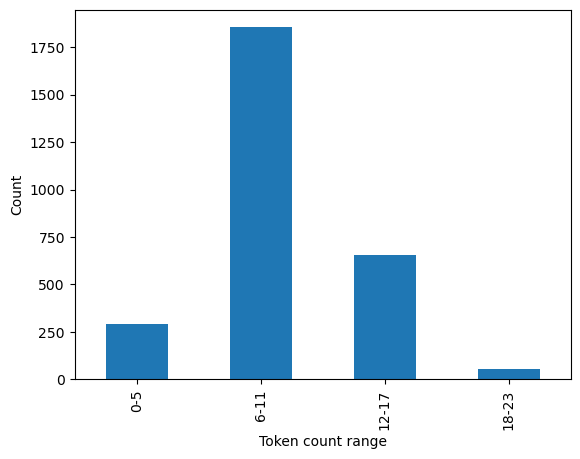

In [105]:
data = test_df['count_belonging']
data.value_counts(sort=False).plot.bar()
plt.xlabel('Token count range')
plt.ylabel('Count')
plt.savefig(os.path.join(figures_dir, f'{training_name}_counts_per_range.png'))
plt.show()

In [99]:
range_to_valid_predictions_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0}
range_to_element_count_dict = {'0-5': 0, '6-11': 0, '12-17': 0, '18-23': 0}
range_to_pred_accuracy_dict = {'0-5': 0., '6-11': 0., '12-17': 0., '18-23': 0.}

In [100]:
for _, row in test_df.iterrows():
    count_belonging = row['count_belonging']

    range_to_element_count_dict[count_belonging] = range_to_element_count_dict[count_belonging] + 1

    if row['correctly_predicted']:
        range_to_valid_predictions_count_dict[count_belonging] = range_to_valid_predictions_count_dict[count_belonging] + 1

for key in range_to_pred_accuracy_dict.keys():
    range_to_pred_accuracy_dict[key] = range_to_valid_predictions_count_dict[key] / range_to_element_count_dict[key]

print("Correct predictions count: ", range_to_valid_predictions_count_dict)
print("Element count: ", range_to_element_count_dict)
print("Accuracies: ", range_to_pred_accuracy_dict)

Correct predictions count:  {'0-5': 243, '6-11': 1575, '12-17': 576, '18-23': 56}
Element count:  {'0-5': 291, '6-11': 1855, '12-17': 654, '18-23': 57}
Accuracies:  {'0-5': 0.8350515463917526, '6-11': 0.8490566037735849, '12-17': 0.8807339449541285, '18-23': 0.9824561403508771}


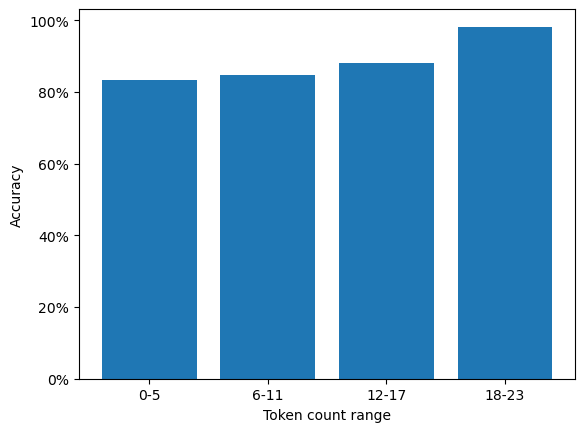

In [106]:
import matplotlib.ticker as mtick

plt.bar(['0-5', '6-11', '12-17', '18-23'], [val for val in range_to_pred_accuracy_dict.values()])
plt.xlabel('Token count range')
plt.ylabel('Accuracy')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
plt.savefig(os.path.join(figures_dir, f'{training_name}_accuracies_per_range.png'))
plt.show()